In [1]:
%load_ext autoreload
import os
import sys

In [82]:
os.environ['TRANSFORMERS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ['HF_DATASETS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ["OPENAI_API_KEY"]= 'xxx'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
sys.path.append('./src-py')

In [83]:
import json
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import re
from collections import Counter

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


%autoreload
import utils
import prompts
import random

from tabulate import tabulate
import tiktoken
from llm_based_evaluation import *

In [84]:
from transformers import AutoTokenizer, pipeline

In [85]:
import json
keys = json.load(open('./keys.json'))
for key, val in keys.items():
    os.environ[key] = val

In [80]:
from huggingface_hub import login

login(os.environ['hf_token'])

In [72]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/'
models_folder = "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/"

In [73]:
gpt_tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

In [90]:
ds_path = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500/'

### Evaluate Science Models

- Now we will evalaute the following models on a sample from the test set using only the generic prompt
    - LLAMA-3 baseline
    - Qwen baseline
    - LLAMA-3 fine-tuned on DeepSeek generated conversations
    - Qwen  fine-tuned on DeepSeek generated conversations

### Evaluation

#### Basic Evaluation

In [42]:
generated_convs = {
    #'llama3-baseline':datasets.load_from_disk(ds_path + '/baseline-advanced-prompt-llama3-test-conv-ds/'),
    'qwen-baseline':datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv'),
    'ft-qwen-on-deepseek' :datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv'),
    'llama-baseline':datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv'),
    'ft-llama-on-deepseek' :datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv'),
}

In [33]:
# generated_convs['qwen-baseline'] = generated_convs['qwen-baseline'].map(lambda row: {'pr-article': paper_id_to_article[row['paper_id']]})
# generated_convs['ft-qwen-on-deepseek'] = generated_convs['ft-qwen-on-deepseek'].map(lambda row: {'pr-article': paper_id_to_article[row['paper_id']]})

In [35]:
print('Results on 500 sample')
all_synth_conversations = utils.evalaute_convs(generated_convs)

Results on 500 sample


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prompt                  Rouge-1    Rouge-L    BERT-f1
--------------------  ---------  ---------  ---------
qwen-baseline             0.292      0.124      0.823
ft-qwen-on-deepseek       0.301      0.126      0.811
llama-baseline            0.325      0.142      0.817
ft-llama-on-deepseek      0.377      0.154      0.824


#### LLM-based Evaluation

#### Using Mixtral:

In [14]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'),ds_path +  '/ft_llama3_gen_conv/'],
}

In [10]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, evaluator_name="mistralai/Mixtral-8x7B-v0.1", force_generation=False)

#### Using GPT-4

In [91]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'),ds_path +  '/ft_llama3_gen_conv/'],
}

In [92]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, evaluator_name="gpt-4.1-2025-04-14", force_generation=False)

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_qwen_gen_conv/ds_eval/gpt-4.1-2025-04-14 from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_qwen_gen_conv//ds_eval/gpt-4.1-2025-04-14 from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_llama3_gen_conv/ds_eval/gpt-4.1-2025-04-14 from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_llama3_gen_conv//ds_eval/gpt-4.1-2025-04-14 from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.85                      2                       2.72   3.19
ft-qwen-on-deepseek                    

#### Using DeepSeek

In [93]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'),ds_path +  '/ft_llama3_gen_conv/'],
}

In [37]:
print(generated_convs['ft-llama-on-deepseek'][0]['conversation'][8])

Journalist: Thank you for sharing this interesting article. I'd like to clarify a few points to better understand the implications of this study.

1. Could you explain why traditional methods for assessing AAV transduction patterns have limitations, especially in terms of detecting transient or low-level expression?

2. How exactly does the new method using editing-dependent reporter mice improve upon these traditional methods?

Researcher: I'd be happy to help clarify the limitations of traditional methods and how the new method using editing-dependent reporter mice addresses these limitations.

1. Traditional methods for assessing AAV transduction patterns, such as using reporter genes like eGFP or lacZ, have limitations because they rely on detecting high and stable expression of the reporter gene. This means that cells that only transiently express the reporter gene or express it at very low levels may not be detected. This is a problem because:
	* Transient expression may be suffi

In [38]:
print(generated_convs['qwen-baseline'][0]['conversation'][7])

Journalist: Given the significant breakthrough in achieving high-speed flexible diodes, I'm curious about the specific challenges you faced when transitioning from glass substrates to flexible plastic substrates. How did the properties of IGZO change under these different substrates, and what modifications were necessary to maintain the diode's performance? Could you explain in simpler terms how the radio-frequency mesa structures helped improve the diode's speed and efficiency?

Researcher: Transitioning from glass to flexible plastic substrates posed several challenges, primarily related to mechanical flexibility and thermal stability. Glass is rigid and can withstand high-temperature processes, whereas plastic is flexible and needs to remain stable at room temperature. When IGZO was deposited on glass, it had good uniformity and crystallinity, which contributed to its high electron mobility. However, when transferred to plastic, the IGZO layer often showed increased roughness and re

In [39]:
print(generated_convs['qwen-baseline'][0]['conversation'][7])

Journalist: Given the significant breakthrough in achieving high-speed flexible diodes, I'm curious about the specific challenges you faced when transitioning from glass substrates to flexible plastic substrates. How did the properties of IGZO change under these different substrates, and what modifications were necessary to maintain the diode's performance? Could you explain in simpler terms how the radio-frequency mesa structures helped improve the diode's speed and efficiency?

Researcher: Transitioning from glass to flexible plastic substrates posed several challenges, primarily related to mechanical flexibility and thermal stability. Glass is rigid and can withstand high-temperature processes, whereas plastic is flexible and needs to remain stable at room temperature. When IGZO was deposited on glass, it had good uniformity and crystallinity, which contributed to its high electron mobility. However, when transferred to plastic, the IGZO layer often showed increased roughness and re

In [16]:
print(generated_convs['ft-qwen-on-deepseek'][0]['conversation'][7])

Journalist: Based on the provided information, here are some questions to explore the key points of the scientific paper:

1. **Materials and Techniques**:
   - What specific materials and techniques were used to fabricate the flexible IGZO diodes?
   - How does the use of IGZO contribute to achieving high-speed performance compared to other materials?

2. **Performance Metrics**:
   - What is the maximum frequency achieved by the flexible IGZO diodes, and how does it compare to the benchmark speed of 2.45 GHz?
   - What are the intrinsic and extrinsic components that determine the diode's cut-off frequency?

3. **Manufacturing Process**:
   - What are the key advantages of using room-temperature processing over high-temperature annealing for flexibility?
   - How does the fabrication process on flexible plastic substrates differ from traditional glass substrates?

4. **Applications and Future Directions**:
   - What are the implications of this technology for the development of flexib

In [94]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]
llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_qwen_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_qwen_gen_conv//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_llama3_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_llama3_gen_conv//ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.04                      2.32                    1.82   2.73
ft-qwen-on-deepseek                    3.93                      2.

In [45]:
print('Old dataset')
llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Old dataset
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_qwen_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_qwen_gen_conv//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_llama3_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_llama3_gen_conv//ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.04                      2.32                    1.82   2.73
ft-qwen-on-deepseek                    3.93            

In [20]:
# generated_convs['ft-llama3-on-deepseek'][0] = generated_convs['ft-llama3-on-deepseek'][0].map(lambda row: {'conversation': '\n\n'.join(['{}: {}'.format('Journalist', x['content']) if x['role'] == 'assistant' else '{}: {}'.format('Researcher', x['content']) for x in row['generated_conversation'][1:]])})
# generated_convs['llama3-baseline'][0] = generated_convs['llama3-baseline'][0].map(lambda row: {'conversation': '\n\n'.join(['{}: {}'.format('Journalist', x['content']) if x['role'] == 'assistant' else '{}: {}'.format('Researcher', x['content']) for x in row['generated_conversation'][1:]])})
# generated_convs['gpt3-baseline'][0] = generated_convs['gpt3-baseline'][0].remove_columns(['societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed'])
# generated_convs['llama3-baseline'][0] = generated_convs['llama3-baseline'][0].remove_columns(['societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed'])
# generated_convs['ft-llama3-on-deepseek'][0] = generated_convs['ft-llama3-on-deepseek'][0].remove_columns(['societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed'])

-------

#### Evaluating the ground-truth generated convs:

In [54]:
gt_convs = {
    'original_deepseek_conv_1': [datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds/').select(range(500)), '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds/'],
    'original_deepseek_conv_2': [datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds-updated/').select(range(500)), '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds-updated/']}

In [55]:
gt_convs['original_deepseek_conv_1'][0] = gt_convs['original_deepseek_conv_1'][0].remove_columns(['scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'])
gt_convs['original_deepseek_conv_2'][0] = gt_convs['original_deepseek_conv_2'][0].remove_columns(['scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'])

In [57]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_gt_results = llm_based_evaluation(prompts_to_eval, gt_convs, force_generation=False)

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds-updated//ds_eval/deepseek-ai from already saved file
#                           clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
------------------------  ---------------------  ------------------------  ----------------------  -----
original_deepseek_conv_1                   4.57                      2.76                    1.98   3.1
original_deepseek_conv_2                   4.59                      2.83                    2.04   3.15


------

### Analysis of the automatic evalaution

In [1]:
# To add the topic to the data
# deepseek_conv_dataset = datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds-cleaned/')
# paper_id_to_article = {x['id']: x['pr-article'] for x in deepseek_conv_dataset}
# paper_id_to_topic = {x['id']: x['Topic'] for x in deepseek_conv_dataset}

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [12]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),  ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'), ds_path +  '/ft_llama3_gen_conv/'],
}

In [13]:
# generated_convs['llama3-baseline-adv-prompt'][0] = generated_convs['llama3-baseline-adv-prompt'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})
# generated_convs['qwen-baseline-adv-prompt'][0] = generated_convs['qwen-baseline-adv-prompt'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})
# generated_convs['ft-llama3-on-deepseek'][0] = generated_convs['ft-llama3-on-deepseek'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})
# generated_convs['ft-qwen-on-deepseek'][0] = generated_convs['ft-qwen-on-deepseek'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})

In [14]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_qwen_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/ft_qwen_gen_conv//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_llama3_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/ft_llama3_gen_conv//ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          3.94                      2.28                    1.82   2.68
ft-qwen-on-deepseek                    3.94            

In [ ]:
utils.histogram_of_scores(llm_eval_results, 'clarity_eval_prompt_scoring_parsed', 'Clarity Scores')

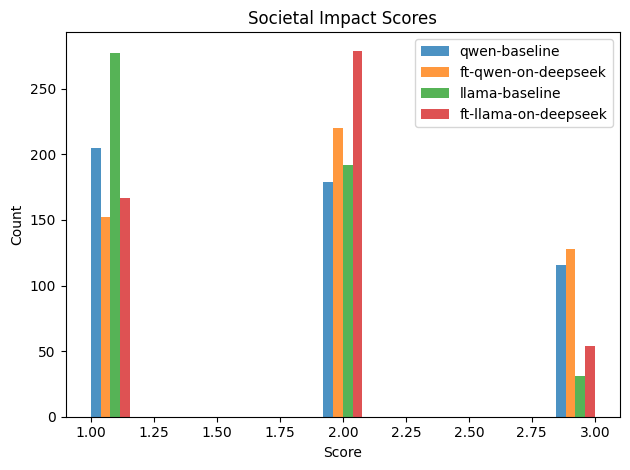

In [57]:
utils.histogram_of_scores(llm_eval_results, 'societal_eval_prompt_scoring_parsed', 'Societal Impact Scores')

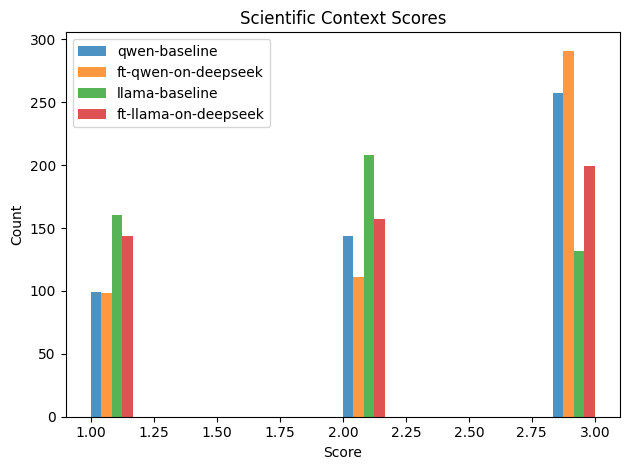

In [58]:
utils.histogram_of_scores(llm_eval_results, 'scientific_eval_prompt_scoring_parsed', 'Scientific Context Scores')

### Per topic analysis

In [44]:
for topic in set(paper_id_to_topic.values()):
    topic_ds = llm_eval_results['qwen-baseline'].filter(lambda row: row['topic'] ==topic)
    print(topic, '#inst: ', len(topic_ds))
    print(tabulate(
        [[name] + get_llm_avg_scores(res.filter(lambda row: row['topic'] ==topic), prompts_to_eval) for name, res in llm_eval_results.items()],
        headers=['#'] + [p['strategy_name'] for p in prompts_to_eval] + ['Avg']
    ))
    print()
    print('===============')

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Nano #inst:  27


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.74                      2.07                    2.7    3.17
ft-qwen-on-deepseek                    4.63                      2.26                    2.89   3.26
llama-baseline                         4.81                      1.48                    2.07   2.79
ft-llama-on-deepseek                   4.81                      2.07                    2.78   3.22



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Physics #inst:  47


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.79                      2.13                    2.26   3.06
ft-qwen-on-deepseek                    4.77                      2.38                    2.77   3.31
llama-baseline                         4.89                      2.02                    1.96   2.96
ft-llama-on-deepseek                   4.72                      2.34                    2.77   3.28



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Computer #inst:  13


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                             5                      1.85                    2.46   3.1
ft-qwen-on-deepseek                       5                      2                       2.69   3.23
llama-baseline                            5                      1.46                    2.08   2.85
ft-llama-on-deepseek                      5                      2.31                    2.54   3.28



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Other #inst:  18


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          5                         2.11                    2.89   3.33
ft-qwen-on-deepseek                    4.72                      2.56                    2.89   3.39
llama-baseline                         4.94                      1.56                    2.56   3.02
ft-llama-on-deepseek                   5                         2                       2.89   3.3



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Medicine #inst:  198


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.82                      1.99                    2.88   3.23
ft-qwen-on-deepseek                    4.69                      2.25                    2.89   3.28
llama-baseline                         4.84                      1.8                     2.49   3.04
ft-llama-on-deepseek                   4.86                      1.85                    2.85   3.19



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Biology #inst:  94


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.87                      1.89                    2.79   3.18
ft-qwen-on-deepseek                    4.7                       2.19                    2.85   3.25
llama-baseline                         4.94                      1.79                    2.41   3.05
ft-llama-on-deepseek                   4.97                      1.97                    2.73   3.22



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Chemistry #inst:  44


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.86                      1.84                    2.39   3.03
ft-qwen-on-deepseek                    4.68                      2                       2.89   3.19
llama-baseline                         4.98                      1.73                    2      2.9
ft-llama-on-deepseek                   4.91                      1.98                    2.8    3.23



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Space #inst:  9


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          5                         2.22                    2.56   3.26
ft-qwen-on-deepseek                    4.67                      2.44                    3      3.37
llama-baseline                         4.78                      2.11                    2.56   3.15
ft-llama-on-deepseek                   5                         2.33                    3      3.44



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Earth #inst:  50


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.88                      2.14                    2.78   3.27
ft-qwen-on-deepseek                    4.8                       2.34                    3      3.38
llama-baseline                         4.9                       1.86                    2.6    3.12
ft-llama-on-deepseek                   4.86                      2.26                    2.88   3.33



In [59]:
import tiktoken

[{key: np.mean([len(conv.split()) for conv in val['conversation']]) for key, val in llm_eval_results.items()}]

[{'qwen-baseline': 1675.34,
  'ft-qwen-on-deepseek': 1610.802,
  'llama-baseline': 1387.936,
  'ft-llama-on-deepseek': 923.026}]

#### Correlation between GPT and Deepseek evaluators

In [66]:
from scipy.stats import spearmanr

In [60]:
deepseek_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")
gpt_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="gpt-4.1-2025-04-14")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_qwen_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_qwen_gen_conv//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_llama3_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_llama3_gen_conv//ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.04                      2.32                    1.82   2.73
ft-qwen-on-deepseek                    3.93                      2.

In [80]:
eval_aspect = 'clarity_eval_prompt_scoring_parsed'
deepseek_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in deepseek_eval_results.items() for row in ds}
gpt_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in gpt_eval_results.items() for row in ds}
print('Correlation on {} is {}'.format(eval_aspect, spearmanr(list(deepseek_scores.values()), list(gpt_scores.values()))))

Correlation on clarity_eval_prompt_scoring_parsed is SignificanceResult(statistic=0.22530488617129796, pvalue=1.960896430851374e-24)


In [81]:
eval_aspect = 'scientific_eval_prompt_scoring_parsed'
deepseek_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in deepseek_eval_results.items() for row in ds}
gpt_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in gpt_eval_results.items() for row in ds}
print('Correlation on {} is {}'.format(eval_aspect, spearmanr(list(deepseek_scores.values()), list(gpt_scores.values()))))

Correlation on scientific_eval_prompt_scoring_parsed is SignificanceResult(statistic=0.424956699021101, pvalue=1.6254632506459045e-88)


In [82]:
eval_aspect = 'societal_eval_prompt_scoring_parsed'
deepseek_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in deepseek_eval_results.items() for row in ds}
gpt_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in gpt_eval_results.items() for row in ds}
print('Correlation on {} is {}'.format(eval_aspect, spearmanr(list(deepseek_scores.values()), list(gpt_scores.values()))))

Correlation on societal_eval_prompt_scoring_parsed is SignificanceResult(statistic=0.3768263847627926, pvalue=1.6939219987298108e-68)


#### Correlation of what model is better

In [84]:
deepseek_eval_results

{'qwen-baseline': Dataset({
     features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', 'pr-article', 'topic', '__index_level_0__', 'generated_conversation', 'conversation', 'clarity_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'],
     num_rows: 500
 }),
 'ft-qwen-on-deepseek': Dataset({
     features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', 'pr-article', 'topic', '__index_level_0__', 'generated_conversation', 'conversation', 'clarity_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'],
     num_rows: 500
 }),
 'llama-baseline': Dataset({
     features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', 'pr-article', 'topic', '__index_level_0__', 'generated_conversation', 'conversation', 'clarity_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'],
   

In [97]:
eval_aspect    = 'clarity_eval_prompt_scoring_parsed'
deepseek_paper_scorings = np.array([[row[eval_aspect]['score'] for row in ds] for model, ds in deepseek_eval_results.items()]).T
gpt_paper_scorings = np.array([[row[eval_aspect]['score'] for row in ds] for model, ds in gpt_eval_results.items()]).T

In [115]:
gpt_paper_scorings

array([[5, 5, 5, 5],
       [5, 5, 5, 5],
       [5, 5, 5, 5],
       ...,
       [5, 5, 5, 5],
       [5, 5, 5, 5],
       [5, 5, 5, 5]])

In [116]:
deepseek_paper_scorings

array([[2, 5, 5, 4],
       [5, 5, 4, 5],
       [5, 3, 4, 4],
       ...,
       [4, 3, 2, 4],
       [4, 4, 5, 4],
       [4, 5, 5, 5]])